# Some ideas for spectral MC Simulations

In [1]:
import luxpy as lx
import numpy as np
from matplotlib import pyplot
%matplotlib inline


from empir19nrm02.spectral import McSpectrumX, generate_FourierMC0
from empir19nrm02.tools import plotHistScales, plotHistScalesWl, plotHistScalesValue, \
                              array2analyse, analyse_stat, seaborn_plot_basedata, seaborn_plot_result, sumMC
from empir19nrm02.f1prime import py_f1PrimeG,  py_f1PrimeGlx

# Parameter for the simulation
#### Let's modify some standard data first and caculate some integrated valeus like $f_{1}^{'}$ and Yxy tristimulus values

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
# let's use the V(Lambda) Function (0 ... X, 1...Y, 2...Z)
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 10000

fig_number = 1
fig_type= '.svg'

def get_fig_file_name(filename=None):
    global fig_number
    global fig_type
    if filename is None:
        file_name = r'met\Fig' + str(fig_number) + fig_type
        fig_number+=1
    else:
        file_name = r'met\Fig' + filename + fig_type
    return file_name

def save_fig(filename=None):
    return pyplot.savefig( get_fig_file_name(filename), bbox_inches='tight', pad_inches=0)

# MC Simulation
Define some data to work with (let's start with the $V(\lambda)$ function)


In [3]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], \
    wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
    kind = 'S')
res = len(lxCmfInterpolate[0])

# Data storage
Take a nominal wavelength scale and the ideal detector and sore all together into a class instance SPD from luxpy

In [4]:
wl=lxCmfInterpolate[0].reshape(1,res)
value=lxCmfInterpolate[2].reshape(1,res)
spd_init = np.r_[wl, value]

# Scale to recerence?
True    all graphs will be shown as difference to the reference
False   all graphs will be shown as they are (without referencing the data)

In [5]:
scale_to_reference = True

# MC Steps?
All MC simulation include several steps (one step for every parameter in the model). The useage of these steps can be
selected here.

At the end, all selected parameters needs to be switched on together for the combined uncertainty.

In [6]:
mc_enable = { 'nothing': True,
              'wl_noise_nc': True,
              'wl_noise_c': True,
              'wl_fourier_noise':True,
              'value_noise_nc': True,
              'value_noise_c': True,
              'value_fourier_noise':True,
              'all': True,
              }

### Array contining instances of the class SPD to store the results of the MC simulation

In [7]:
array_mc = np.ndarray((trials,),dtype=object)

### Array contining the integral results (here $f_{1}^{'}$ for an scalar output)

In [8]:
result1 = np.zeros( (3, trials))

### Array contining the integral results (here Yxy for a moredimensional  output)

In [9]:
result3 = np.zeros( (3, trials))

# Running the MC simulation

In [10]:
def MC_simulation(mc_enable_loc):
    global array_mc
    global result1
    global result3

    class mc_budget_table:
        name = 'empty'
        mean = 0.0
        stddev = 0.0
        nb = 0
        dist = ''
        Y = 0
        x = 0
        y = 0
        sY = 0
        sx = 0
        sy = 0
        f1p=0
        f1pL=0
        f1ppR=0
        sf1p=0
        sf1pL=0
        sf1ppR=0

    print(mc_enable_loc)
    #mc_budget_table_array
    mc_bta_loc = [mc_budget_table() for i in mc_enable_loc]

    #for iMC in ['all']:
    for iMC in mc_enable_loc:
        # do nothing if a contribution is not enabled
        if mc_enable_loc[iMC] == False: continue

        # initialise the result data arrays
        result1.fill(0)
        result3.fill(0)

        # init the spectral array with the reference distribution to add some noise later on
        for i in range(trials):
            array_mc[i] = McSpectrumX(spd_init)

        # for all trials
        d_nb = 0
        d_mean = 0
        d_stddev = 0
        d_dist = 'none'
        for i in range(0, trials):
            # no noise for the first item as reference for later investigations
            if i != 0:
                if mc_enable_loc['wl_noise_nc'] and (iMC == 'wl_noise_nc' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 1
                    d_dist = 'normal'
                    array_mc[i].add_wl_noise_nc( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['wl_noise_c'] and (iMC == 'wl_noise_c' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 1
                    d_dist = 'normal'
                    array_mc[i].add_wl_noise_c( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['wl_fourier_noise'] and (iMC == 'wl_fourier_noise' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 1
                    d_dist = 'F'
                    d_nb = 1
                    array_mc[i].add_wl_fourier_noise( array_mc[0], d_nb, stddev=1.)

                if mc_enable_loc['value_noise_nc'] and (iMC == 'value_noise_nc' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 0.01
                    d_dist = 'normal'
                    array_mc[i].add_value_noise_nc( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['value_noise_c'] and (iMC == 'value_noise_c' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 0.01
                    d_dist = 'normal'
                    array_mc[i].add_value_noise_c( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['value_fourier_noise'] and (iMC == 'value_fourier_noise' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 0.01
                    d_dist = 'F'
                    d_nb = 1
                    array_mc[i].add_value_fourier_noise( array_mc[0], d_nb, stddev=d_stddev)

            # calculate some sample integral data from the generated distribution

            [result1[0, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A')
            [result1[1, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='LED_B3')
            [result1[2, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='E', dCutOff=-0.003)
            result3[:,i] = lx.xyz_to_Yxy(array_mc[i].spd.to_xyz(relative=False).value)


        print("i=", iMC)

        if iMC=='all':
            # Show all the graphs only for the final result
            if mc_enable_loc['wl_noise_nc'] == True and mc_enable_loc['value_noise_nc'] == False:
                analyse = array2analyse(array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
                print('Statistic for the wavelength scale')
                analyse_stat( array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
                save_fig(filename='MC_wl_All')
                plotHistScalesWl( analyse)

            if mc_enable_loc['value_noise_nc'] == True and mc_enable_loc['wl_noise_nc'] == False :
                analyse = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
                print('Statistic for the value scale')
                analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
                save_fig(filename='MC_value_All')
                plotHistScalesValue( analyse)
        # Calculate the sensitivity
        idx = list(mc_enable_loc.keys()).index(iMC)
        mc_bta_loc[idx].name = iMC
        erg=np.mean(result3, axis=1)
        mc_bta_loc[idx].Y=erg[0]
        mc_bta_loc[idx].x=erg[1]
        mc_bta_loc[idx].y=erg[2]
        serg=np.std(result3, axis=1)
        mc_bta_loc[idx].sY=serg[0]
        mc_bta_loc[idx].sx=serg[1]
        mc_bta_loc[idx].sy=serg[2]

        erg=np.mean(result1, axis=1)
        mc_bta_loc[idx].f1p=erg[0]
        mc_bta_loc[idx].f1pL=erg[1]
        mc_bta_loc[idx].f1ppR=erg[2]
        serg=np.std(result1, axis=1)
        mc_bta_loc[idx].sf1p=serg[0]
        mc_bta_loc[idx].sf1pL=serg[1]
        mc_bta_loc[idx].sf1ppR=serg[2]
        if iMC!='all':
            mc_bta_loc[idx].mean = d_mean
            mc_bta_loc[idx].stddev = d_stddev
            mc_bta_loc[idx].dist = d_dist
            mc_bta_loc[idx].nb = d_nb
    return mc_bta_loc

# Simulation for the wavelength scale

{'nothing': False, 'wl_noise_nc': True, 'wl_noise_c': True, 'wl_fourier_noise': True, 'value_noise_nc': False, 'value_noise_c': False, 'value_fourier_noise': False, 'all': True}
i= wl_noise_nc
i= wl_noise_c
i= wl_fourier_noise
i= all
Statistic for the wavelength scale
Value= [-0.00043059073894730196, 1.8576500191429932] Inteval(95%)= 7.223490569385831
Value= [-0.00043059073894730196, 1.8576500191429932] Inteval(95%)= 7.223490569385831


F:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


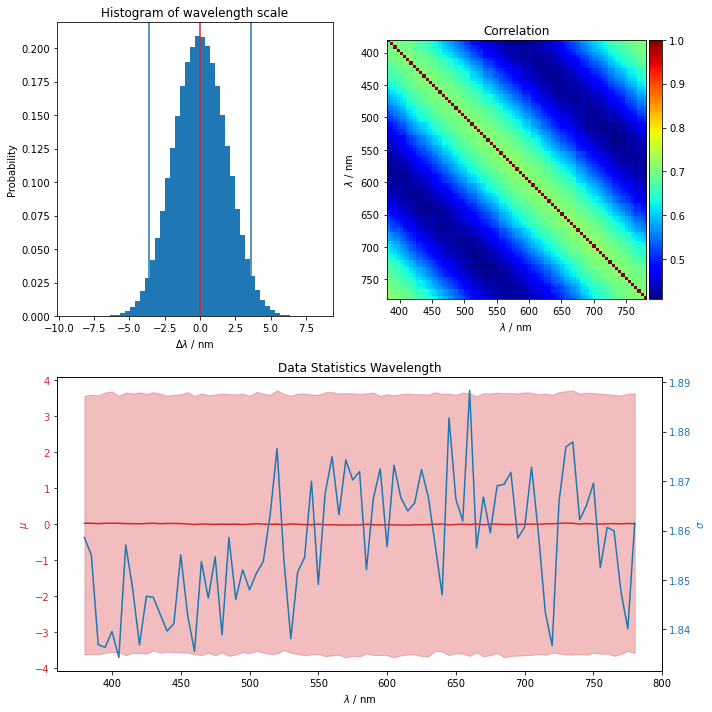

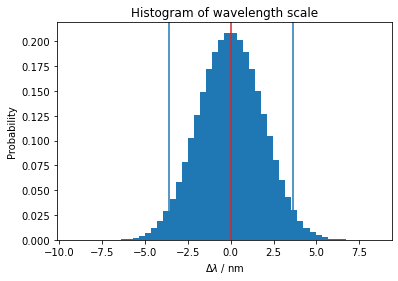

In [11]:
mc_wl = mc_enable.copy()
for key in mc_wl:
    mc_wl[key]=False
mc_wl['wl_noise_c']=True
mc_wl['wl_noise_nc']=True
mc_wl['wl_fourier_noise']=True
mc_wl['all']=True

mc_bta=MC_simulation( mc_wl)

# Simulation for the value scale

{'nothing': False, 'wl_noise_nc': False, 'wl_noise_c': False, 'wl_fourier_noise': False, 'value_noise_nc': True, 'value_noise_c': True, 'value_fourier_noise': True, 'all': True}
i= value_noise_nc
i= value_noise_c
i= value_fourier_noise
i= all
Statistic for the value scale
Value= [8.193052323624351e-05, 0.01514108878677465] Inteval(95%)= 0.05943493761300872
Value= [8.193052323624351e-05, 0.01514108878677465] Inteval(95%)= 0.05943493761300872


F:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


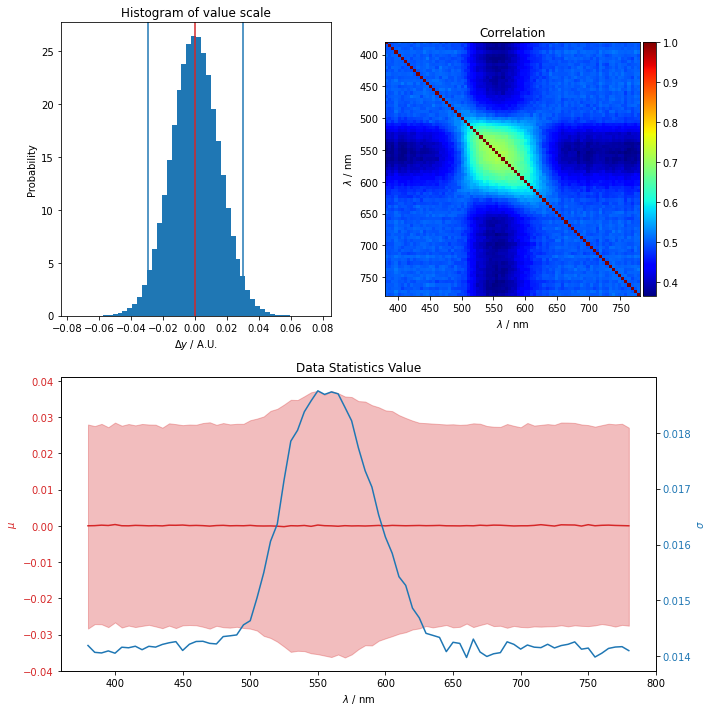

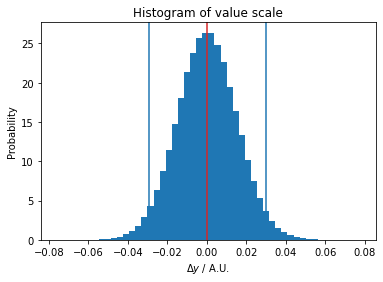

In [12]:
mc_value = mc_enable.copy()
for key in mc_value:
    mc_value[key]=False
mc_value['value_noise_c']=True
mc_value['value_noise_nc']=True
mc_value['value_fourier_noise']=True
mc_value['all']=True

mc_bta=MC_simulation( mc_value)

# Simulation for the all together

In [13]:
mc_all = mc_enable.copy()
mc_bta=MC_simulation( mc_all)

{'nothing': True, 'wl_noise_nc': True, 'wl_noise_c': True, 'wl_fourier_noise': True, 'value_noise_nc': True, 'value_noise_c': True, 'value_fourier_noise': True, 'all': True}
i= nothing
i= wl_noise_nc
i= wl_noise_c
i= wl_fourier_noise
i= value_noise_nc
i= value_noise_c
i= value_fourier_noise
i= all


In [23]:
eps=1e-6

def t_out( number, sigfigs=4):
    if abs(number)<eps:
        return round(str(number), decimals=sigfigs)
    else:
        return round(str(number), sigfigs=sigfigs)

import pyperclip
from prettytable import PrettyTable
#from prettytable import MSWORD_FRIENDLY
from sigfig import round

x_table = PrettyTable()
#x_table.set_style(MSWORD_FRIENDLY)
x_table.field_names = ["Contribution", "Mean", "Std. Dev.", "NB", "Distribution",
                       #"Y","x","y", "sY","sx","sy",
                       "f1p","f1pL","f1ppR","sf1p","sf1pL","sf1ppR"]

for i in mc_enable:
    idx = list(mc_enable.keys()).index(i)
    if i == 'all':
        x_table.add_row([mc_bta[idx].name, '', '',
                         '', '',
                        #t_out(mc_bta[idx].Y), t_out(mc_bta[idx].x), t_out(mc_bta[idx].y),
                        #t_out(mc_bta[idx].sY, 2), t_out(mc_bta[idx].sx, 2), t_out(mc_bta[idx].sy, 2),
                        t_out(mc_bta[idx].f1p), t_out(mc_bta[idx].f1pL), t_out(mc_bta[idx].f1ppR),
                        t_out(mc_bta[idx].sf1p, 2), t_out(mc_bta[idx].sf1pL, 2), t_out(mc_bta[idx].sf1ppR, 2)])
    else:
        x_table.add_row([mc_bta[idx].name, mc_bta[idx].mean, mc_bta[idx].stddev,
                         mc_bta[idx].nb, mc_bta[idx].dist,
                        #t_out(mc_bta[idx].Y), t_out(mc_bta[idx].x), t_out(mc_bta[idx].y),
                        #t_out(mc_bta[idx].sY, 2), t_out(mc_bta[idx].sx, 2), t_out(mc_bta[idx].sy,2),
                        t_out(mc_bta[idx].f1p), t_out(mc_bta[idx].f1pL), t_out(mc_bta[idx].f1ppR),
                        t_out(mc_bta[idx].sf1p, 2), t_out(mc_bta[idx].sf1pL, 2), t_out(mc_bta[idx].sf1ppR, 2)])

print(x_table)

pyperclip.copy(x_table.get_csv_string())

+---------------------+------+-----------+----+--------------+----------+----------+----------+--------+--------+--------+
|     Contribution    | Mean | Std. Dev. | NB | Distribution |   f1p    |   f1pL   |  f1ppR   |  sf1p  | sf1pL  | sf1ppR |
+---------------------+------+-----------+----+--------------+----------+----------+----------+--------+--------+--------+
|       nothing       |  0   |     0     | 0  |     none     |  0.0000  |  0.0000  |  0.0000  |  0.00  |  0.00  |  0.00  |
|     wl_noise_nc     |  0   |     1     | 0  |    normal    | 0.01511  | 0.01505  | 0.002460 | 0.0020 | 0.0020 | 0.0016 |
|      wl_noise_c     |  0   |     1     | 0  |    normal    | 0.01545  | 0.01505  | 0.01281  | 0.012  | 0.011  | 0.0096 |
|   wl_fourier_noise  |  0   |     1     | 1  |      F       | 0.02021  | 0.01958  | 0.01472  | 0.0098 | 0.0096 | 0.0091 |
|    value_noise_nc   |  0   |    0.01   | 0  |    normal    | 0.03040  | 0.02974  | 0.005913 | 0.0028 | 0.0026 | 0.0032 |
|    value_noise

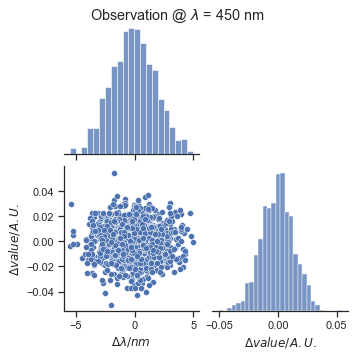

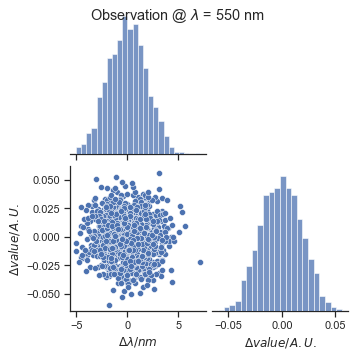

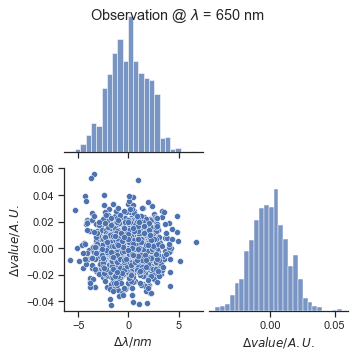

In [15]:
seaborn_plot_basedata(array_mc, wavelength_to_observe = 450)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 550)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 650)

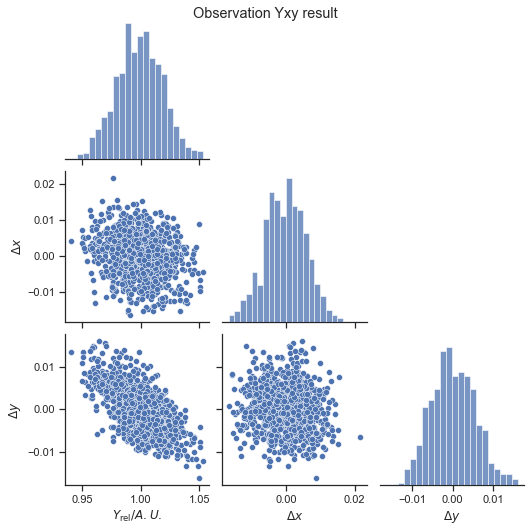

In [16]:
seaborn_plot_result( result3)

In [17]:
import seaborn as sns
import pandas as pd

def seaborn_plot_result_f1prime(loc_result):
    disp_array_count = loc_result.shape[1]
    step=1
    disp_array = np.zeros((3, disp_array_count - 1))
    for i in range(disp_array_count - 1):
        disp_array[0, i] = loc_result[0, i * step + 1] - loc_result[0, 0]
        disp_array[1, i] = loc_result[1, i * step + 1] - loc_result[1, 0]
        disp_array[2, i] = loc_result[2, i * step + 1] - loc_result[2, 0]

    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T, columns=['$\Delta f_{1}^{´}$', '$\Delta f_{1,\mathrm{L}}^{´}$', '$\Delta f_{1,\mathrm{R}}^{´´}$'])
    grid = sns.pairplot(df, corner=True)

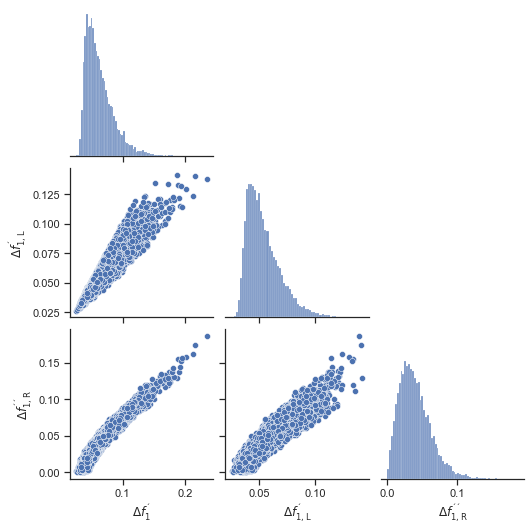

In [18]:
seaborn_plot_result_f1prime( result1)
save_fig( 'MCf1Results')

In [19]:
def FourierTableP( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy (XYZ)
        xData = Yxy[:, 1]
        yData = Yxy[:, 2]
        L = Yxy[:, 0]
        CCT = lx.xyz_to_cct(XYZ)
        CCT.resize(trials)
        # Luminance
        [Lvalues, Linterval] = sumMC(L / np.mean(L), Coverage=0.95)
        #CCT
        [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
        #(x,y)
        [xvalues, xinterval] = sumMC(xData, Coverage=0.95)
        [yvalues, yinterval] = sumMC(yData, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'L_mean': Lvalues[0], 'L_std': Lvalues[1], 'L_95%': (Linterval[1]-Linterval[0])/2., \
            'CCT_mean': CCTvalues[0], 'CCT_std': CCTvalues[1], 'CCT_95%': (CCTinterval[1] - CCTinterval[0]) / 2., \
            'x_mean': xvalues[0], 'x_std': xvalues[1], 'x_95%': (xinterval[1] - xinterval[0]) / 2., \
            'y_mean': yvalues[0], 'y_std': yvalues[1], 'x_95%': (yinterval[1] - yinterval[0]) / 2., \
             } , dtype = 'float')
        petriTable = petriTable.append( df)
        print( numberNew)
    return petriTable

def FourierTablef1p( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        f1p=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pL=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
        f1ppR=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)

        [f1p_values, f1p_interval] = sumMC(f1p, Coverage=0.95)
        [f1pL_values, f1pL_interval] = sumMC(f1pL, Coverage=0.95)
        [f1ppR_values, f1ppR_interval] = sumMC(f1ppR, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'f1p': f1p_values[0], 'f1p_std': f1p_values[1], 'f1p_95%': (f1p_interval[1]-f1p_interval[0])/2., \
            'f1pL': f1pL_values[0], 'f1pL_std': f1pL_values[1], 'f1pL_95%': (f1pL_interval[1]-f1pL_interval[0])/2., \
            'f1ppR': f1ppR_values[0], 'f1ppR_std': f1ppR_values[1], 'f1ppR_95%': (f1ppR_interval[1]-f1ppR_interval[0])/2., \
             } , dtype = 'float')
        petriTable = petriTable.append( df)
        print( numberNew)
    return petriTable
'''
illA = lx._CIE_ILLUMINANTS['A'].copy()
res_illA = illA.shape[1]
# relative to 560nm
illA[1] = illA[1] / illA[1, np.argwhere(illA[0]==560)]
uSPD=np.zeros(res_illA)
uSPD[:]=0.01

petriTable=FourierTableP(10000, illA[0], illA[1], uSPD)
petriTable
'''
bIdeal = False

if bIdeal:
    VL = lx._CMF['1931_2']['bar'][2].copy()
    wl = lx._CMF['1931_2']['bar'][0].copy()
else:
    from empir19nrm02 import _RES
    VL= _RES['VLDetectors']['S']['data'][42].copy()
    wl= _RES['VLDetectors']['S']['data'][0].copy()


f1pOrg=py_f1PrimeG(wl, VL, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
print('f1pOrg=', f1pOrg)
res_VL = wl.shape[0]
uSPD=np.zeros(res_VL)
uSPD[:]=0.01

petriTable=FourierTablef1p(10000, wl, VL, uSPD)
petriTable

f1pOrg= [0.03713304655058624, array([-2.2427e-07, 4.6009e-07, -2.9893e-07, 1.0101e-06, 7.6084e-06,
       2.1680e-05, 3.6490e-05, 4.7059e-05, 5.1237e-05, 4.6214e-05,
       3.7320e-05, 2.4879e-05, 6.8090e-06, -1.4489e-05, -3.6111e-05,
       -4.6916e-05, -2.4662e-05, 5.1337e-05, 1.6217e-04, 2.7362e-04,
       3.3025e-04, 3.0378e-04, 2.0941e-04, 1.0581e-04, 1.0058e-04,
       2.1542e-04, 3.8381e-04, 4.3730e-04, 3.7421e-04, 2.6046e-04,
       1.0089e-04, -2.6227e-05, -1.2032e-04, -1.7946e-04, -2.1004e-04,
       -2.2991e-04, -2.4265e-04, -2.4214e-04, -2.3208e-04, -2.0590e-04,
       -1.7686e-04, -1.4895e-04, -1.2547e-04, -1.0925e-04, -1.0180e-04,
       -1.1035e-04, -1.2315e-04, -1.3559e-04, -1.3092e-04, -8.6075e-05,
       -3.2321e-05, -4.5236e-06, 1.7400e-05, 4.1384e-05, 6.1662e-05,
       7.3265e-05, 8.0603e-05, 8.4168e-05, 8.2220e-05, 7.0388e-05,
       5.4335e-05, 4.3263e-05, 3.3534e-05, 2.5474e-05, 1.9002e-05,
       1.4426e-05, 1.0846e-05, 7.8898e-06, 5.5922e-06, 3.9589e-06,
     

,N,f1p,f1p_std,f1p_95%,f1pL,f1pL_std,f1pL_95%,f1ppR,f1ppR_std,f1ppR_95%
0,0.0,0.037133,3.626785e-17,6.938894e-17,0.035458,2.662710e-17,5.204170e-17,0.020714,4.561327e-17,9.020562e-17
0,1.0,0.037225,1.811905e-03,3.331136e-03,0.035573,2.061369e-03,3.767197e-03,0.020799,2.110246e-03,3.863152e-03
0,2.0,0.037309,3.162439e-03,6.040181e-03,0.035673,3.328558e-03,6.335999e-03,0.020821,2.597112e-03,4.742197e-03
0,3.0,0.037329,3.596638e-03,6.719890e-03,0.035718,3.739065e-03,6.999918e-03,0.020802,2.495289e-03,4.665830e-03
0,4.0,0.037463,3.477399e-03,6.553778e-03,0.035873,3.613380e-03,6.854896e-03,0.020827,2.267348e-03,4.305085e-03
0,5.0,0.037371,3.255722e-03,6.222995e-03,0.035798,3.373309e-03,6.461623e-03,0.020763,2.058087e-03,3.992516e-03
0,6.0,0.037414,3.142716e-03,6.055525e-03,0.035855,3.256313e-03,6.282498e-03,0.020767,1.916294e-03,3.697118e-03
0,7.0,0.037451,2.998777e-03,5.783992e-03,0.035906,3.117431e-03,5.997449e-03,0.020769,1.776076e-03,3.459750e-03
0,8.0,0.037464,2.821099e-03,5.451782e-03,0.035933,2.926053e-03,5.634411e-03,0.020769,1.669821e-03,3.252345e-03
0,9.0,0.037470,2.772072e-03,5.348872e-03,0.035943,2.856777e-03,5.512925e-03,0.020754,1.607679e-03,3.182397e-03


In [20]:
petriTable.to_clipboard(excel=True,  decimal=",")

(0.0, 50.0)

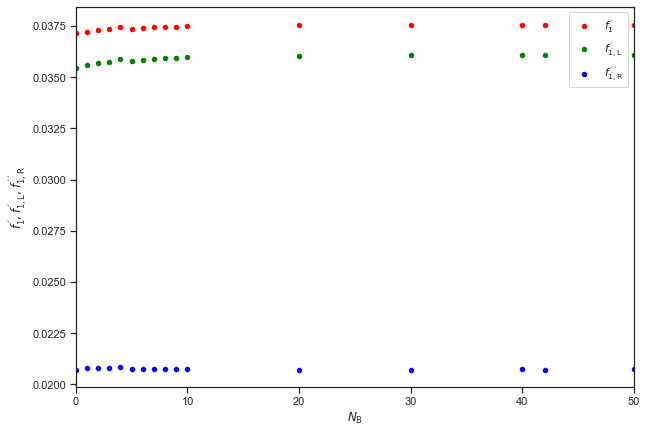

In [21]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="f1p", color="Red", label="$f_{1}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pL", color="Green", label="$f_{1,\mathrm{L}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1ppR", color="Blue", label="$f_{1,\mathrm{R}}^{´´}$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$')
ax1.set_ylabel('$f_{1}^{´}, f_{1,\mathrm{L}}^{´}, f_{1,\mathrm{R}}^{´´} $')
ax1.set_xlim([0,50])

"\n        ax2.plot(x_data, sigma, 'ro', label=ylabel2)\n        ax2.set_ylabel(ylabel2)\n        ax2.spines['right'].set_color('red')\n        ax2.yaxis.label.set_color('red')\n        ax2.tick_params(axis='y', colors='red')\n        lr_model.fit(x, sigma)\n        y_pred_sigma = lr_model.predict(x)\n        m_sigma=lr_model.coef_\n        r_sq = lr_model.score(x, sigma)\n        ax2.plot(x, y_pred_sigma, 'r-', label=str_m_sigma + '= '+ round( str(m_sigma[0]), sigfigs=2) + r' 1/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))\n"

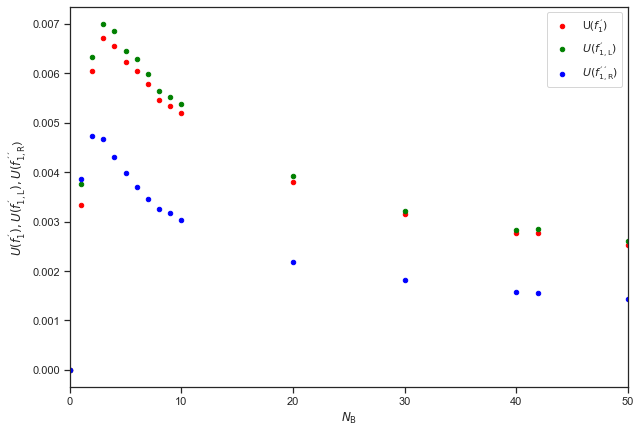

In [22]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="f1p_95%", color="Red", label="U($f_{1}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pL_95%", color="Green", label="$U(f_{1,\mathrm{L}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1ppR_95%", color="Blue", label="$U(f_{1,\mathrm{R}}^{´´})$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$')
ax1.set_ylabel('$U(f_{1}^{´}), U(f_{1,\mathrm{L}}^{´}), U(f_{1,\mathrm{R}}^{´´} $)')
ax1.set_xlim([0,50])


'''
        ax2.plot(x_data, sigma, 'ro', label=ylabel2)
        ax2.set_ylabel(ylabel2)
        ax2.spines['right'].set_color('red')
        ax2.yaxis.label.set_color('red')
        ax2.tick_params(axis='y', colors='red')
        lr_model.fit(x, sigma)
        y_pred_sigma = lr_model.predict(x)
        m_sigma=lr_model.coef_
        r_sq = lr_model.score(x, sigma)
        ax2.plot(x, y_pred_sigma, 'r-', label=str_m_sigma + '= '+ round( str(m_sigma[0]), sigfigs=2) + r' 1/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))
'''